In [1]:
import time
import email
import shutil
import locale
import datetime
from pathlib import Path

import numpy as np
import pandas as pd

locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
parser = email.parser.Parser()

In [3]:
mails = sorted(Path('cobra/cur/').glob('[0-9]*[0-9]'))

In [4]:
dates = []
job_ids = []
run_times = []

for file in mails:
    try:
        mail = parser.parse(open(file))
    except UnicodeDecodeError:
        continue

    subject = mail["Subject"]

    # completed?
    if "COMPLETED" not in subject:
        continue

    # MD?
    if "md" not in subject:
        continue

    # date
    t = time.strptime(mail["Date"], "%a, %d %b %Y %H:%M:%S %z")

    # discard before December
    if t.tm_year == 2019 and t.tm_mon < 12:
        continue
        
    shutil.copy(file, 'cobra_mails')

    date = (t.tm_year, t.tm_yday)
    dates.append(t)

    # runtime
    i = subject.find("Run time")
    s = subject[i:].split()[2].strip(",")
    try:
        t = time.strptime(s, "%H:%M:%S")
    except ValueError:
        print(s)
    timedelta = datetime.timedelta(seconds=t.tm_sec, minutes=t.tm_min, hours=t.tm_hour)
    run_time = timedelta.total_seconds() / 3600 * 6 * 40
    run_times.append(run_time)

In [5]:
print(f'Amount of core hours spent: {np.sum(run_times):.2f} h')

Amount of core hours spent: 961691.00 h


In [6]:
# sort by days
days = []
for date in dates:
    day = (date[0] - 2019) * 366 + date[7] - 366
    days.append(datetime.datetime(*date[0:3]))

In [7]:
series = pd.Series(run_times, index=days)

In [8]:
# group by day and sum to get core hours per day
new_series = series.groupby(series.index).sum()

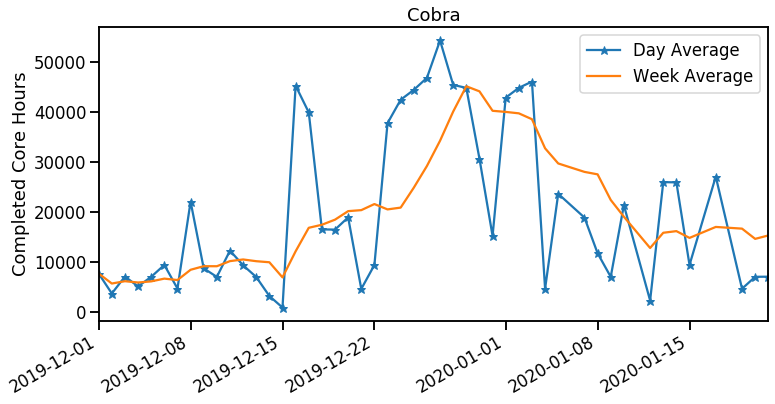

In [9]:
ax = new_series.plot(style="*-", rot=80, figsize=(12, 6), label='Day Average')
new_series.rolling(7, min_periods=1).mean().plot(ax=ax, label='Week Average')
ax.set_title("Cobra")
ax.set_ylabel("Completed Core Hours")
ax.legend()